# COCS2673 Assignment 2 P1A - Is or is not cancel prediction

## Tasks
### Load Data
Split data into train, validation, and test
Note that images for the same patient may contain a mix of cancerous and non-cancerous data.
Q - Sould we split on patient or just randomly

### Measure 
As this is a screening task, the impact of a false negative is high (ie someone who has cancer is missed)
In this case use Recall for measure.
We can also use F1 to get a more balanced measure of Precision and Recall

# Classifiy if image is cancer or not

Use base of the VGG network and adapt to our platform
Reference: [VGG paper](https://arxiv.org/abs/1409.1556)


# Load Data and EDA

In [1]:
import IPython.display as display
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import pandas as pd

In [2]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

In [3]:
#mainData = mainData.append(extraData, ignore_index=True)


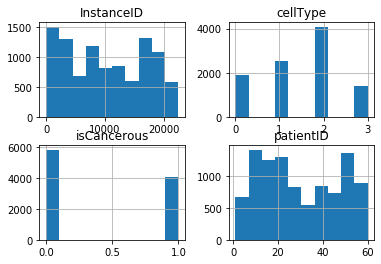

In [4]:
mainData.hist()
plt.show()

In [5]:
vc = mainData.isCancerous.value_counts()
print(vc)
print("Cancerous Percentage ", (vc[1] / (vc[1] + vc[0])) * 100)

0    5817
1    4079
Name: isCancerous, dtype: int64
Cancerous Percentage  41.21867421180275


#### Key observations:
* Data has 20280  observations and 6 columns.
* InstanceID - is Id field, need to remove as not valueable classification attribute
* cellTypeName, cellType - indicator of actual cell type and not used in this case for cancer diagnosis
* isCancerous - indicator of the actual diagnosis (1 = cancerous, 0 = benign)

Split of benign to cancerous is a 1/3 cancerous, 2/3 benign

In [6]:
mainData.drop(['InstanceID', 'cellTypeName', 'cellType'], axis = 1, inplace=True)

In [7]:
print(mainData.shape)
print(mainData.info())
print(mainData.describe())
mainData.head()

(9896, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   patientID    9896 non-null   int64 
 1   ImageName    9896 non-null   object
 2   isCancerous  9896 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.1+ KB
None
         patientID  isCancerous
count  9896.000000  9896.000000
mean     29.762025     0.412187
std      17.486553     0.492253
min       1.000000     0.000000
25%      14.000000     0.000000
50%      26.000000     0.000000
75%      47.000000     1.000000
max      60.000000     1.000000


,patientID,ImageName,isCancerous
0,1,22405.png,0
1,1,22406.png,0
2,1,22407.png,0
3,1,22408.png,0
4,1,22409.png,0


In [8]:
from sklearn.model_selection import train_test_split

trainData, testData = train_test_split(mainData, test_size=0.2, random_state=42)
trainData, valData = train_test_split(trainData, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(trainData.shape[0], valData.shape[0], testData.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [9]:
trainData['Class'] = trainData['isCancerous'].astype('str')
valData['Class'] = valData['isCancerous'].astype('str')
testData['Class'] = testData['isCancerous'].astype('str')

C:\bin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Images

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=valData,
        directory='patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


# Model development

- Start initially on a model based on VGG
- Reference: [VGG paper](https://arxiv.org/abs/1409.1556)

In [11]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1 # flag

In [12]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

**Observations:**
- VGG has 3x3 convolution kernels only.
- Pooling is always max-pooling and they are (2x2).
- Padding is same - No boarder pixels lost when applying convolutions. 
- activation is ReLU

Lets compile the model and fit.

In [13]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
print(datetime.datetime.now().strftime("%H:%M:%S"))
now = datetime.datetime.now()

history = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

print(datetime.datetime.now().strftime("%H:%M:%S"))
print("Took = ", datetime.datetime.now() - now)

15:51:34


C:\bin\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], 'r--')
plt.plot(history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()